## Topic-related analyses

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import plot_topic_volume
from src.colnames import topic_col
from collections import defaultdict
import itertools
from scipy.stats import spearmanr, pearsonr
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

%load_ext autoreload
%autoreload 2

/home/roberta/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

Defining some useful variables

In [3]:
topic_names = ['Economy and markets', 
               'Finance and trade',
               'Growth and Global Development',
               'Strategic Investments (e.g., recovery, research, innovation)', 
               'Health',
               "Citizen Rights and Integration", 
               "Human Rights", 
               'Digital Policy',
               'Digital and Green Transition', 
               'Energy, Sustainability and Climate',
               'Identity, Culture and Citizen Engagement', 
               "Citizen Initiatives",
               'Visions for the Future',
               'Internal Governance',
               'Trade, Partnerships, and Law', 
               'Solidarity and Emergency Response', 
               'Financial Aid',
               'Press conferences and Statements',
               'Charts, Links, Infographics', 
               'Live Events']
categories = ['Economic and Financial Policy'] * 4 + \
             ['Social Policy'] * 3 + \
             ['Environmental and Digital Policy'] * 3 + \
             ['Identity and Citizen Participation'] * 3 + \
             ['Governance'] * 2 + \
             ['Solidarity and Humanitarian Aid'] * 2 + \
             ['Communication and Media'] * 3

In [ ]:
cat_dict = defaultdict(list)
inv_cat_dict = {}

for i,c in enumerate(categories):
    cat_dict[c].append(topic_names[i])
    
for i,t in enumerate(topic_names):
    inv_cat_dict[t] = categories[i]


In [ ]:
preds = pd.read_json('data/topic/preds_extended.jsonl', orient='records', lines=True)

### Plot topic volumes over time
Let's plot topic volume over time, at different levels of granularity (each topics vs. macro-categories)

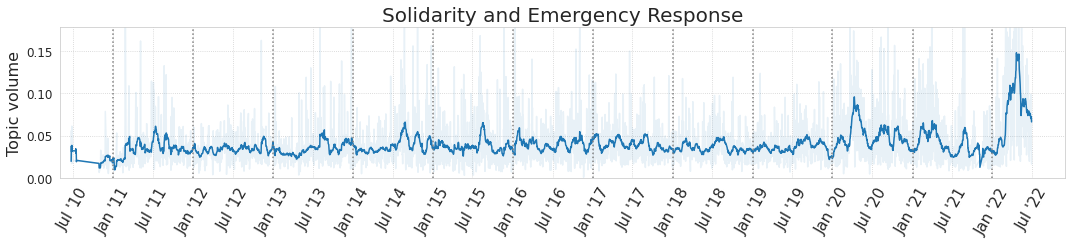

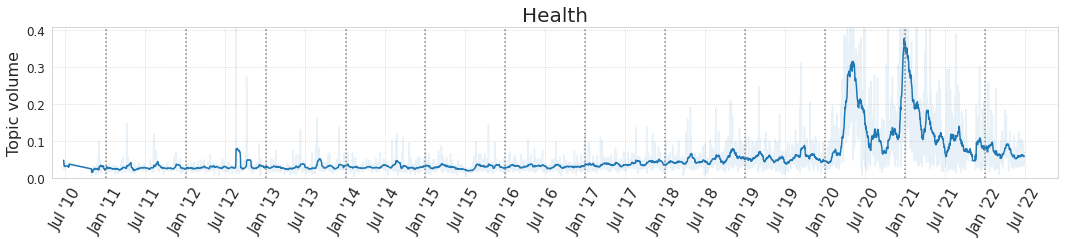

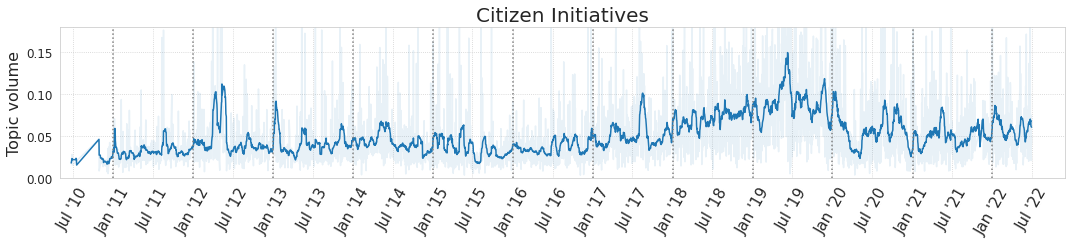

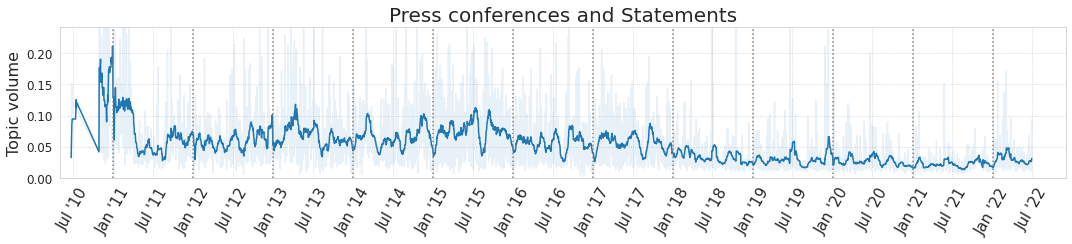

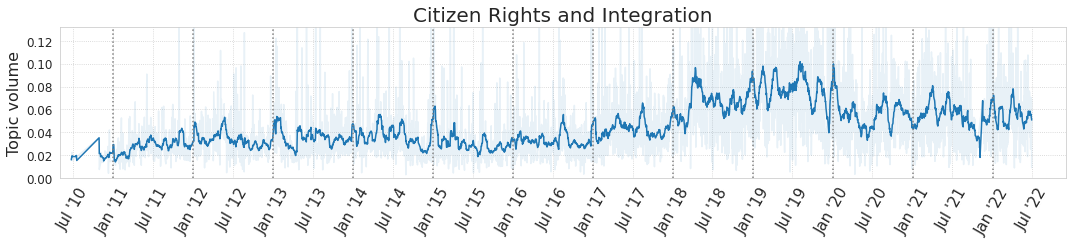

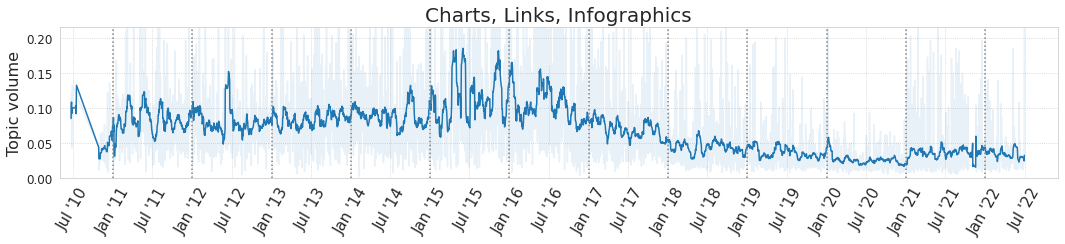

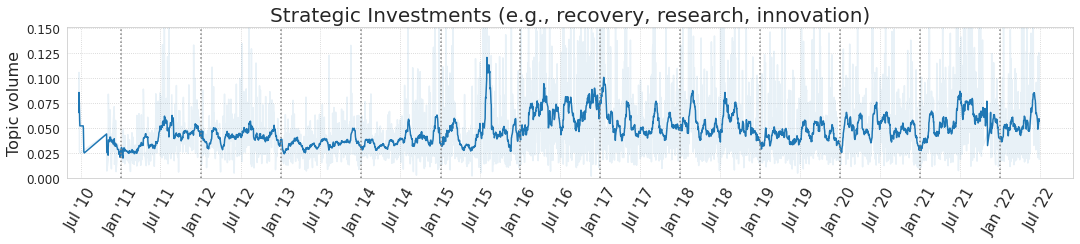

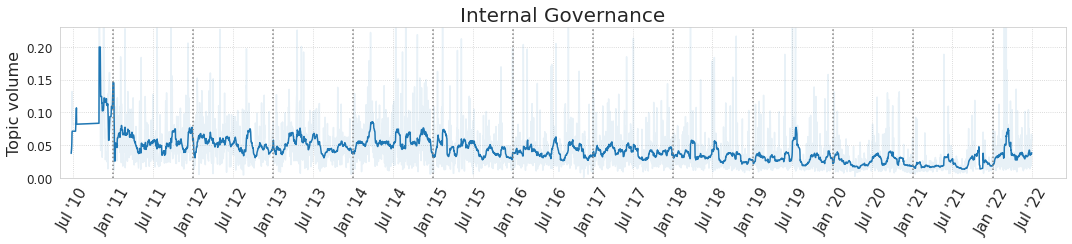

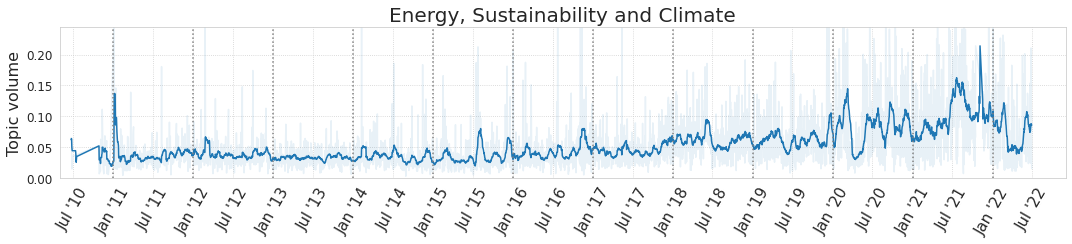

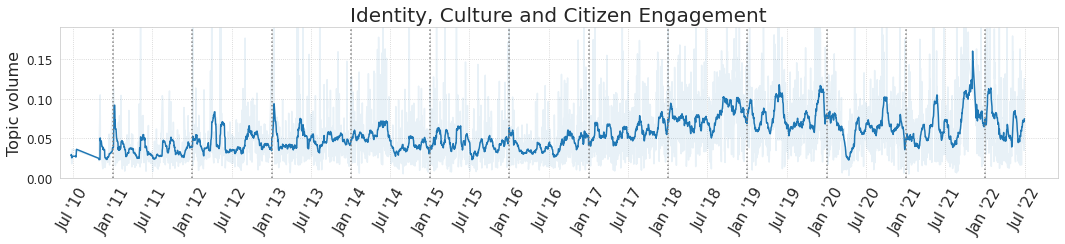

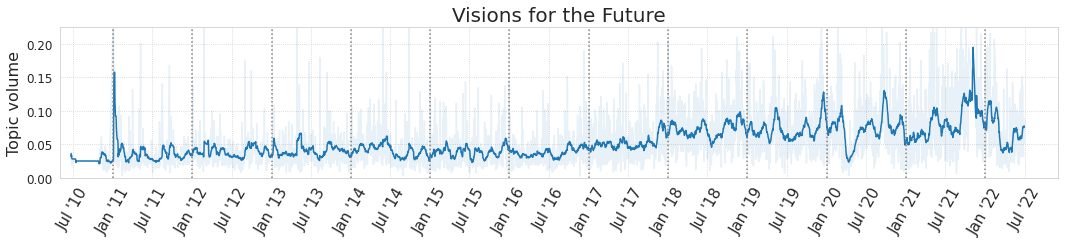

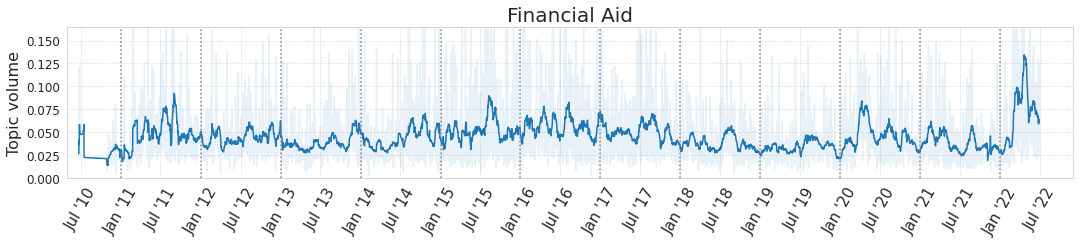

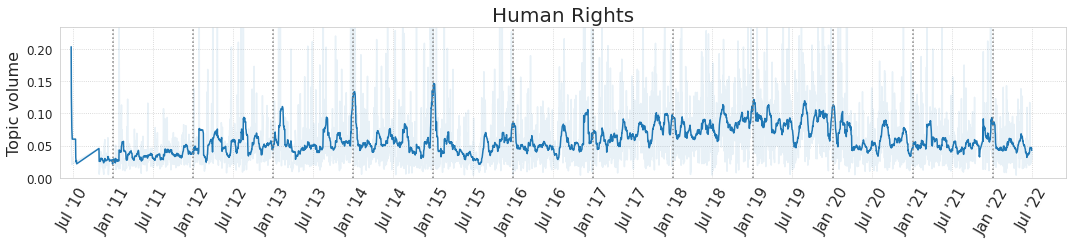

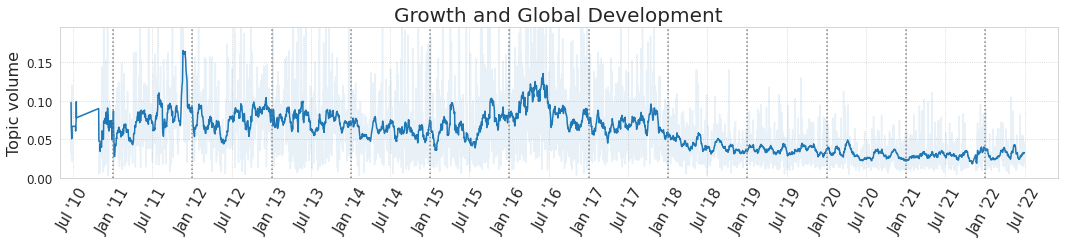

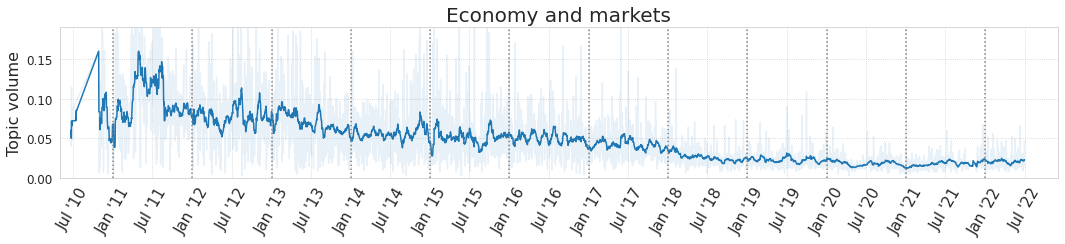

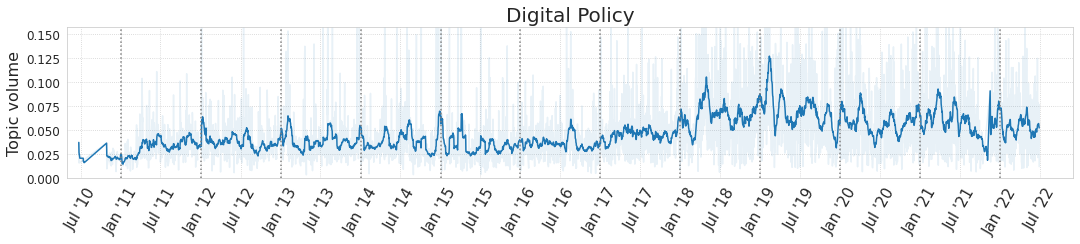

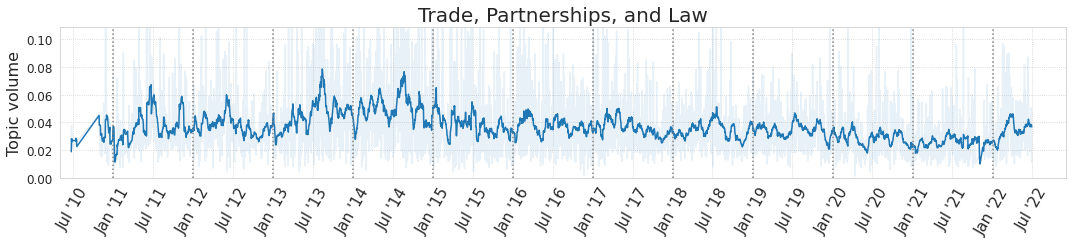

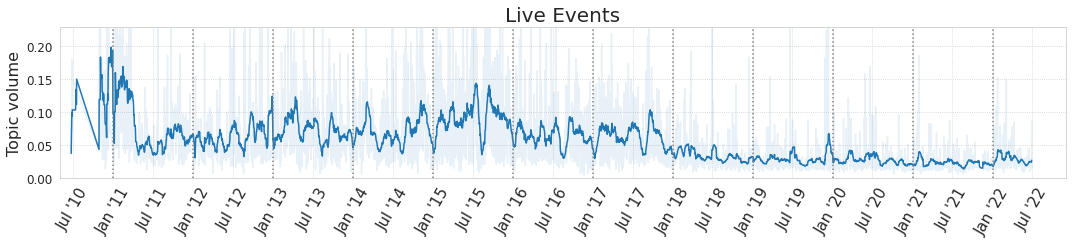

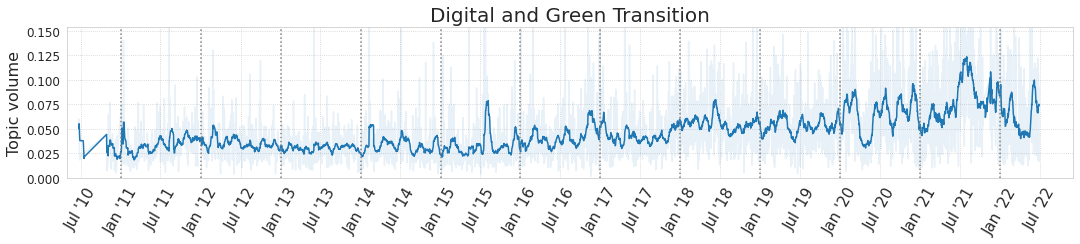

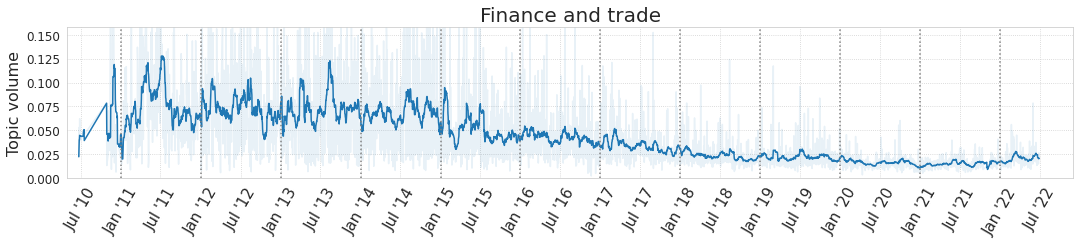

In [16]:
for t in topic_col:
    plot_topic_volume(preds, 
                      entity='EU_Commission',
                      topics=[t],
                      freq='D', roll_window=21,
                      savename=f'micro_volumes/{t}', interactive=False,
                      exclude_topics=set(topic_col) - set([t]),
                      title=t,
                      figsize=(15,3.5),
                      plot_smooth_only=False, 
                      xticksize=15)

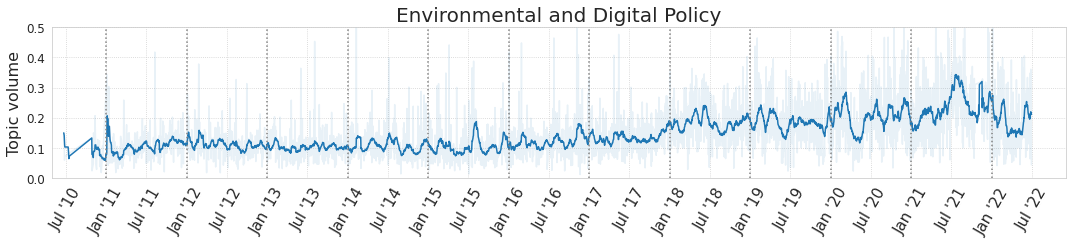

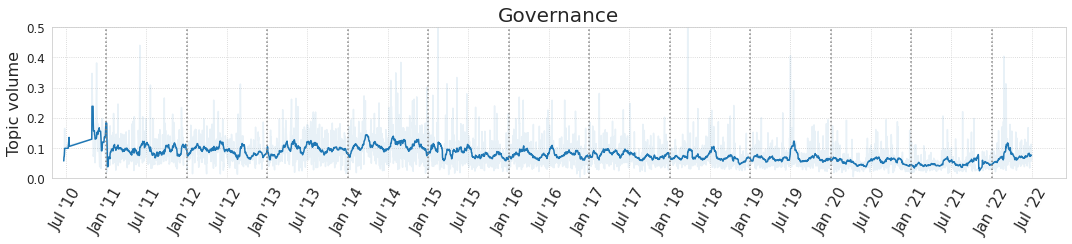

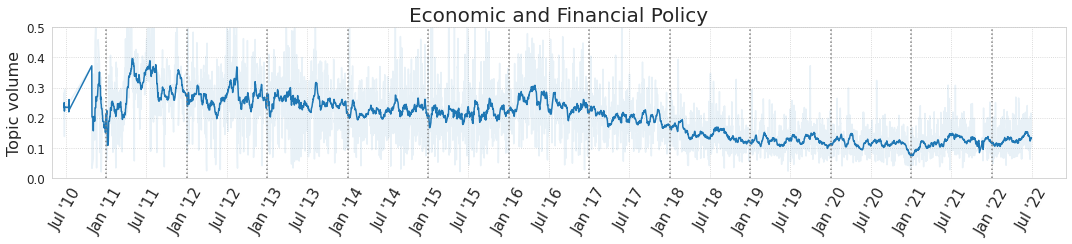

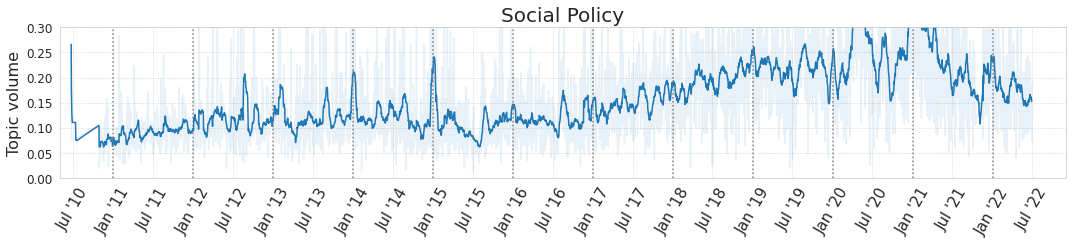

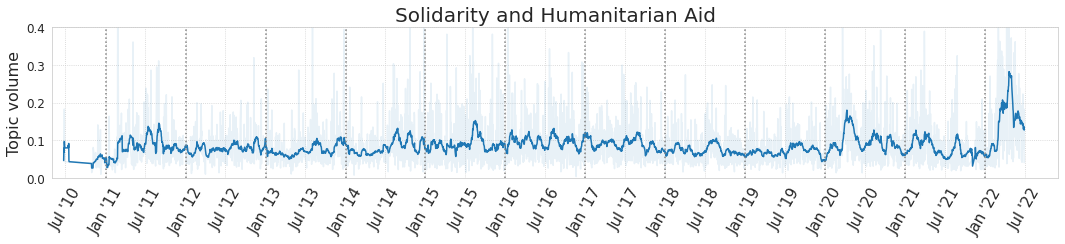

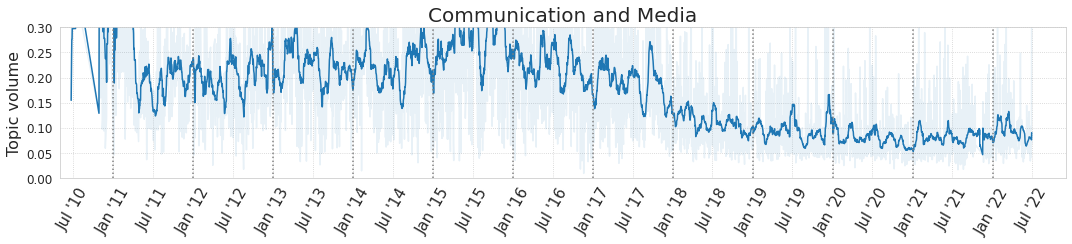

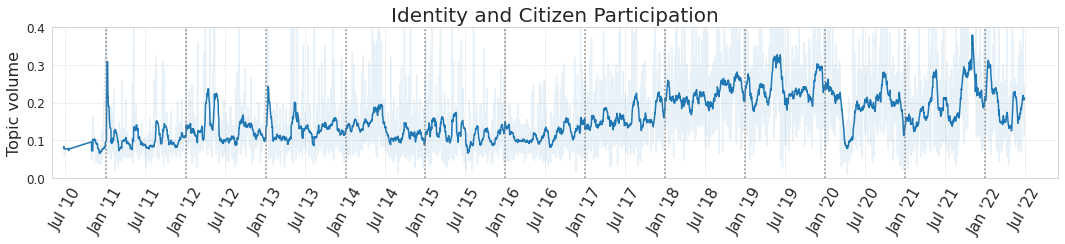

In [17]:
ylims = [0.5, .5, .5, .3, .4, .3, .4]
for i, t in enumerate(set(categories)):
    plot_topic_volume(preds,
                      entity='EU_Commission',
                      topics=categories,
                      freq='D', roll_window=21,
                      savename=f'macro_volumes/{t}', interactive=False,
                      exclude_topics=set(categories) - set([t]),
                      title=t,
                      figsize=(15,3.5),
                      ylim=(0, ylims[i]),
                      plot_smooth_only=False, xticksize=15)

### Year-based averages over time

In [24]:
counts = preds[preds['entity']=='EU_Commission'].groupby(['top_topic', 'year'])['text'].agg(lambda x: x.count()).reset_index()
overall = preds[preds['entity']=='EU_Commission'].groupby(['year'])['text'].agg(lambda x: x.count()).reset_index()
overall = overall.rename({'text': 'overall'}, axis=1) 
counts = counts.merge(overall)
counts['proportion'] = counts['text'] / counts['overall']
counts = counts.sort_values(by='proportion') # sort values
counts['group'] = counts['top_topic'].replace(inv_cat_dict)

Ad hoc fix, to avoid long column names.

In [25]:
no = []
for k in cat_dict.values():
    for a in k:
        if 'Strategic' not in a:
            no.append(a)
        else:
            no.append('Strategic Investments')

Plotting average volume per year

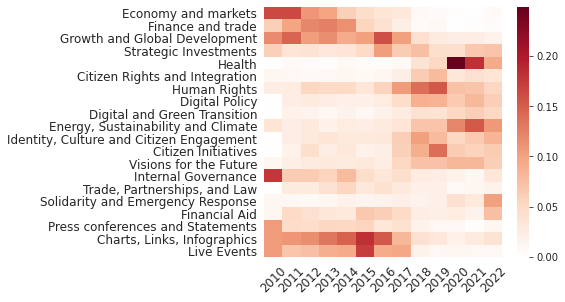

In [26]:
counts = counts.replace({'Strategic Investments (e.g., recovery, research, innovation)': 
                         'Strategic Investments'})
wide = pd.pivot(counts, 
                index='top_topic', 
                columns='year', 
                values='proportion').fillna(0)
wide = wide.T[no].T
plt.subplots(figsize=(8,4.3))
sns.heatmap(wide, 
            cmap='RdGy_r', 
            center=0)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs/topics_heatmap.png', dpi=300)
plt.show()

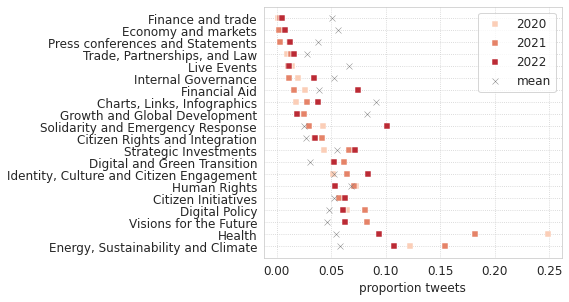

In [27]:
palette = sns.color_palette('RdGy', 7)[:-4][::-1]

plt.subplots(figsize=(8,4.3))
for i, y in enumerate([2020, 2021, 2022]):
    sns.scatterplot(data=counts[counts['year']>=y].sort_values(by='proportion'),
                    y='top_topic', x='proportion', marker='s',
                    label=y, color=palette[i])
sns.scatterplot(data=counts.groupby('top_topic').mean().reset_index().sort_values(by='proportion'),
                y='top_topic', x='proportion', color='grey', marker='x', label='mean')
plt.xlabel('proportion tweets', fontsize=12)
plt.ylabel('')
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig('figs/topics_scatter.png', dpi=300)
plt.show()

### Topic similarity with other agencies

First, compute average volume per month for all agencies

In [28]:
avg_vol = preds.groupby(['year', 'month', 'entity'])[topic_col].mean().reset_index()

Let's now compute Spearman's correlation between topic volume for each pair of agencies (EC vs. other).
We repeat this procedure for each month in the dataset, to get a correlation value for each agency and each month.

In [30]:
entities = list(itertools.combinations(preds.entity.unique(), 2))
cors = []
for year in preds.year.unique():
    for month in preds.month.unique():
        for e0, e1 in entities:
            if e0 == 'EU_Commission' or e1 == 'EU_Commission':
                s = []
                for e in [e0, e1]:
                    s.append(avg_vol[(avg_vol['year']==year) & \
                                     (avg_vol['month']==month) & \
                                     (avg_vol['entity']==e)][topic_col].values)
                if len(s[0]) > 0 and len(s[1]) > 0: 
                    c = spearmanr(s[0][0],s[1][0]).correlation
                    if e0 == 'EU_Commission':
                        cors.append((year, month, e1, c)) 
                    else:
                        cors.append((year, month, e0, c)) 

Reshape the data and index all values to respective month.

In [31]:
cor_df = pd.DataFrame(cors, columns=['year', 'month', 'entity', 'cor'])
cor_df['date'] = pd.to_datetime(cor_df[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(cor_df[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique()
dct = dict(zip(vals, range(vals.shape[0])))
cor_df['date_mapped'] = cor_df['date'].replace(dct)
cor_df = cor_df.sort_values(by='date_mapped')
inv_dct = dict(zip(dct.values(), dct.keys()))
cor_df['values'] = cor_df.groupby(['entity'])['cor'].transform(lambda x: x.rolling(3,1).mean())

Plot the data.

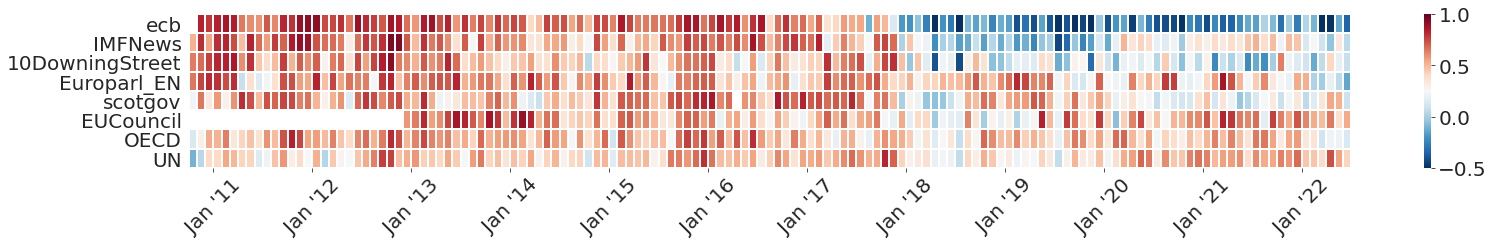

In [32]:
cc = cor_df.pivot(index='entity', columns='date_mapped', values='cor')
cc = cc.T[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
         '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
cc = cc.T
plt.subplots(figsize=(23,3.5))
ax = sns.heatmap(cc, cmap='RdBu_r', 
                 vmin=-.5, vmax=1, linewidth=.005)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=20)
plt.xticks(ticks=np.arange(3,143,12),
           labels=[f'Jan \'{inv_dct[k][5:]}' for k in np.arange(3,143,12)],
           rotation=45, fontsize=20)
ax.xaxis.tick_bottom()
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig('figs/similarity_heatmap.png', dpi=300)
plt.show()

Also plotting a more detailed time series for each of the agencies (reported in the supplementary materials) 

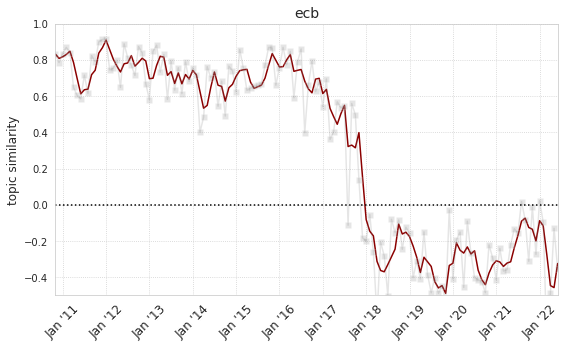

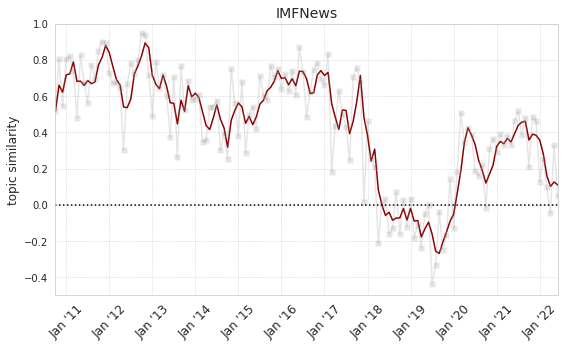

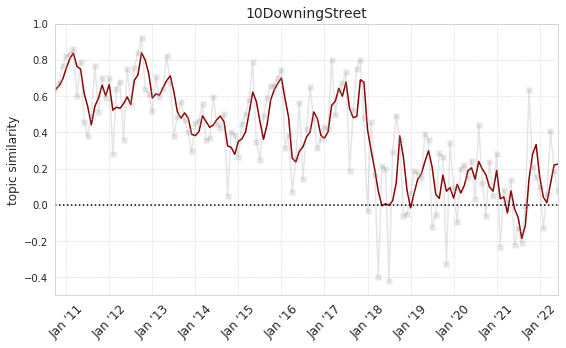

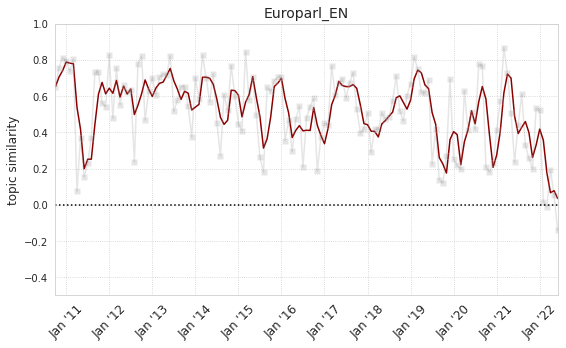

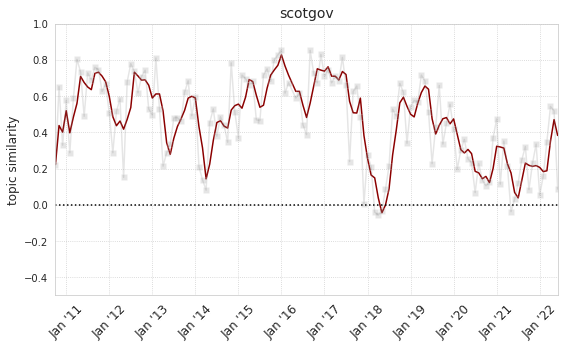

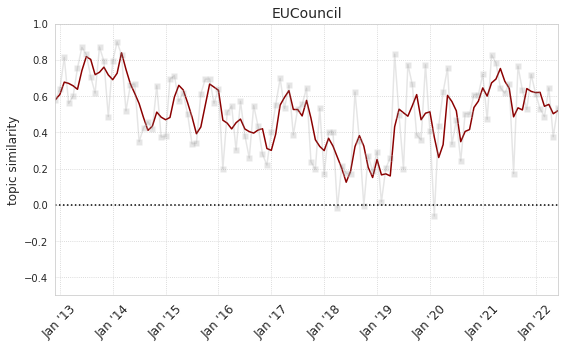

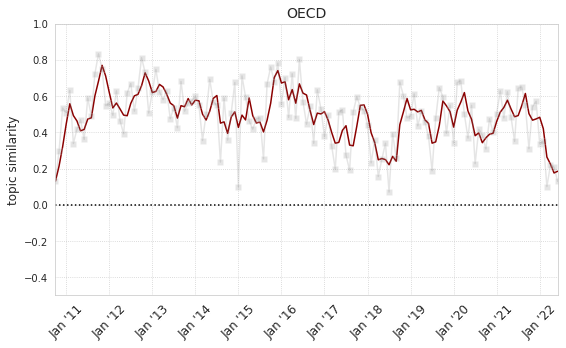

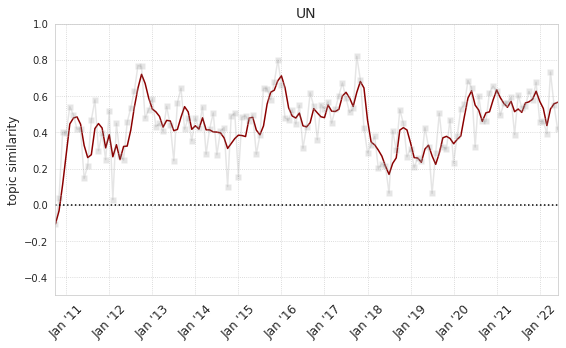

In [918]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

for entity in ['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
               '10DowningStreet', 'IMFNews', 'ecb'][::-1]:
    fig, ax = plt.subplots(figsize=(9,5))
    plt.title(f'{entity}', fontsize=14)
    edf = cor_df[cor_df['entity']==entity]
    sns.lineplot(data=edf, x='date_mapped', y='values', color='darkred')
    sns.lineplot(data=edf, x='date_mapped', y='cor', color='grey',
                 alpha=.2, marker='s')
    plt.xticks(ticks=[v for k,v in dct.items() if 'Jan' in k], 
               labels=[k for k,v in dct.items() if 'Jan' in k], 
               rotation=45, fontsize=12)
    plt.axhline(0, color='black', linestyle='dotted')
    plt.ylabel('topic similarity', fontsize=12)
    plt.xlim((edf['date_mapped'].dropna().min(), edf['date_mapped'].dropna().max()))
    plt.ylim(-.5,1)
    plt.xlabel('')
    plt.savefig(f'figs/simtime/{entity}.png', dpi=300)
    sns.despine(left=False, right=False, top=False)
    plt.show()

### Aligning tweet volume to engagement

In this section, we correlate volume and engagement data for each topic over time, to find out if the EC (and other agencies) learn from feedback given by previous engagement patterns.
First step is extracting the rank of topics in terms of both volume and engagement.

In [ ]:
eng = preds.groupby(['entity', 
                     'year', 
                     'month', 
                     'top_topic']).sum_count.agg(['count', 'median'])
eng = eng.reset_index()
eng['date'] = pd.to_datetime(eng[['year', 'month']].assign(day=1)).dt.strftime('%b \'%y')
vals = pd.to_datetime(eng[['year', 'month']].assign(day=1)).sort_values().dt.strftime('%b \'%y').unique() # , 'month'
dct = dict(zip(vals, range(vals.shape[0])))
eng['date_mapped'] = eng['date'].replace(dct)

In [35]:
topics = eng.top_topic.unique()
ranks = []
for e in eng.entity.unique():
    ent_sub = eng[eng['entity']==e]
    for i in range(len(vals)-1):
        
        sub = ent_sub[ent_sub['date']==vals[i]]
        
        if sub.shape[0]>0:
            sub = sub.sort_values(by='median', ascending=False)
            sub_count = ent_sub[ent_sub['date']==vals[i+1]]
            if sub_count.shape[0]>0:
                sub_count = sub_count.sort_values(by='count', ascending=False)
                for t in topics:
                    idx = [i for i,tp in enumerate(sub.top_topic) if tp == t]
                    if len(idx) > 0:
                        idx = idx[0]
                    else:
                        idx = np.nan
                    idx_count = [i for i,tp in enumerate(sub_count.top_topic) if tp == t]
                    if len(idx_count) > 0:
                        idx_count = idx_count[0]
                    else:
                        idx_count = np.nan
                    ranks.append((e, vals[i+1], t, idx, idx_count))
                    
rank_df = pd.DataFrame(ranks, columns=['entity', 
                                       'date', 
                                       'topic', 
                                       'rank_engagement', 
                                       'rank_nr']).dropna()

Here we compute correlations between topics' ranking in volume and engagement over time. We correlate volume at time `t` with engagement ranking at time `t-1`.

In [36]:
cors = []
for e in rank_df.entity.unique():
    ent_sub = rank_df[rank_df['entity']==e]
    for i in range(len(vals)-1):
        sub = ent_sub[ent_sub['date']==vals[i+1]]
        if sub.shape[0] > 1:
            c =  pearsonr(sub.rank_nr.tolist(),
                          sub.rank_engagement.tolist())[0]
            cors.append((e, vals[i+1], c))

For each entity, we also fit a regression with an indicator for time (month number) as regressor, and correlation values as outcome, to understand whether alignment increases over time. We print parameters and p-values for each entity.

In [39]:
cordata = pd.DataFrame(cors, columns=['entity', 'date', 'value'])
cordata['month'] = cordata['date'].replace(dct)
vallist = []

coefdict = {}
for e in rank_df.entity.unique():
    sub = cordata[cordata['entity']==e].sort_values(by='month')
    mod = smf.ols(formula='value ~ month', data=sub)
    res = mod.fit()
    print(e, 'beta:', round(res.params[1],3), 'p:', round(res.pvalues[1],3)) 
    coefdict[e] = {'coeff': round(res.params[1],4),
                   'p': round(res.pvalues[1],3)}
    
    with open(f'summaries/alignment/{e}.txt', 'w') as t:
        t.write((res.summary().as_latex()))
        
    vallist.append((e, round(res.params[1],4), round(res.pvalues[1],3)))

cordata = cordata.rename({'value': 'Pearson\'s r'}, axis=1)

10DowningStreet beta: -0.001 p: 0.215
EUCouncil beta: -0.0 p: 0.932
EU_Commission beta: 0.004 p: 0.0
Europarl_EN beta: 0.001 p: 0.053
IMFNews beta: 0.0 p: 0.504
OECD beta: -0.001 p: 0.397
UN beta: 0.001 p: 0.223
ecb beta: -0.003 p: 0.0
scotgov beta: -0.001 p: 0.298


Saving these values into a Latex table.

In [40]:
pd.DataFrame(vallist, columns=['entity', 
                               'beta', 
                               'p-value']).sort_values(by='beta',
                                                       ascending=False).to_latex('summaries/alignment/parameters.txt')

... and plotting the values for all agencies, with colors indicating whether regression coefficients are positive, negative, or non-significant.

In [43]:
# let's map month indices into month ids
long_dct = dict(zip(range(cordata['date'].nunique() - 16), 
                    cordata[cordata['entity']=='10DowningStreet'].sort_values(by='month').date.tolist()[16:]))

... and let's plot

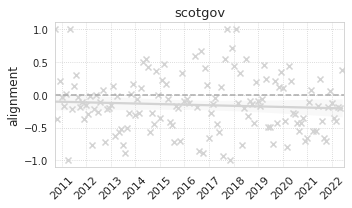

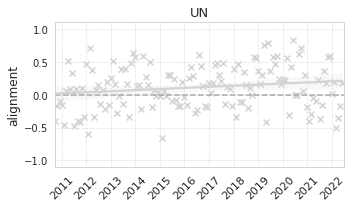

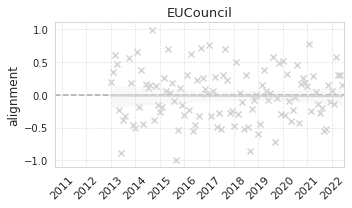

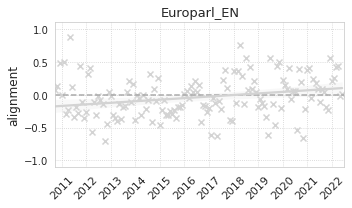

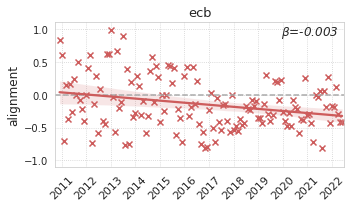

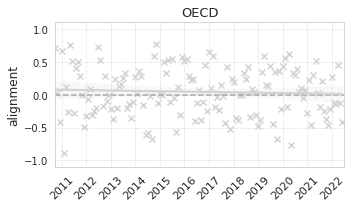

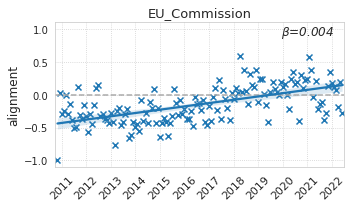

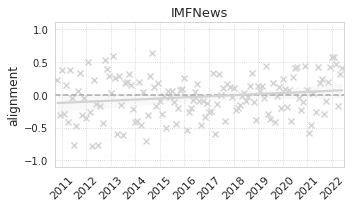

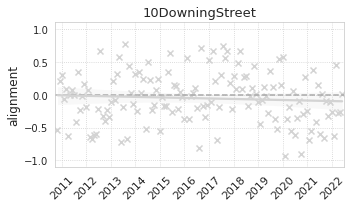

In [44]:
for e in preds.entity.unique():
    plt.subplots(figsize=(5,3))
    plt.axhline(linestyle='--', y=0, color='darkgrey')
    if coefdict[e]['p'] >= 0.05:
        color = 'lightgrey'
    elif coefdict[e]['coeff'] > 0:
        color = sns.color_palette()[0]
    else:
        color = 'indianred'
    sns.regplot(data=cordata[cordata['entity']==e][cordata['month']>=21], 
                x='month', y='Pearson\'s r', 
                marker='x',
                color=color,
                robust=True, scatter_kws={'color': color,
                                          'alpha': 1})
    plt.xlim(21,162)
    plt.ylim(-1.1,1.1)
    plt.xticks(ticks=np.arange(21+3,161,12),
               labels=[f'20{long_dct[k-21][5:]}' for k in np.arange(21+3,161,12)],
               rotation=45, fontsize=11)
    plt.xlabel('')
    plt.ylabel('alignment', fontsize=12)
    plt.title(e, fontsize=13)
    if not coefdict[e]['p']>=0.05:
        plt.annotate(xy=(131,0.9), style='italic', text=rf'$\beta$={coefdict[e]["coeff"]}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'figs/alignment/{e}.png', dpi=300)
    plt.show()